In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.datasets import mnist
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


Using TensorFlow backend.


## Load Data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_validation, y_train, y_validation = train_test_split( X_train, y_train, test_size=0.4, random_state=42)

In [4]:
X_train.shape

(36000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
X_validation.shape

(24000, 28, 28)

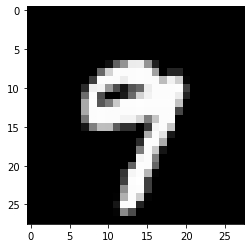

In [7]:
plt.imshow(X_train[1], cmap='gray')

In [8]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_validation = X_validation.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
X_validation = X_validation.reshape((len(X_validation), np.prod(X_validation.shape[1:])))

In [9]:
X_train.shape

(36000, 784)

In [10]:
X_test.shape

(10000, 784)

In [11]:
X_validation.shape

(24000, 784)

## Auto encoder 

In [12]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# intermediate result
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'] )

In [13]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [14]:
print("Computing Encoding Representation")
history =autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
               )
result = autoencoder.evaluate(X_validation, X_validation)

Computing Encoding Representation
Epoch 1/50
36000/36000 [==============================] - 2s 45us/step - loss: 0.1662 - accuracy: 0.0052
Epoch 2/50
36000/36000 [==============================] - 1s 26us/step - loss: 0.0740 - accuracy: 0.0072
Epoch 3/50
36000/36000 [==============================] - 1s 25us/step - loss: 0.0706 - accuracy: 0.0074
Epoch 4/50
36000/36000 [==============================] - 1s 25us/step - loss: 0.0694 - accuracy: 0.0076
Epoch 5/50
36000/36000 [==============================] - 1s 25us/step - loss: 0.0681 - accuracy: 0.0075
Epoch 6/50
36000/36000 [==============================] - 1s 25us/step - loss: 0.0667 - accuracy: 0.0083
Epoch 7/50
36000/36000 [==============================] - 1s 25us/step - loss: 0.0648 - accuracy: 0.0095
Epoch 8/50
36000/36000 [==============================] - 1s 26us/step - loss: 0.0626 - accuracy: 0.0112
Epoch 9/50
36000/36000 [==============================] - 1s 25us/step - loss: 0.0604 - accuracy: 0.0126
Epoch 10/50
36000/360

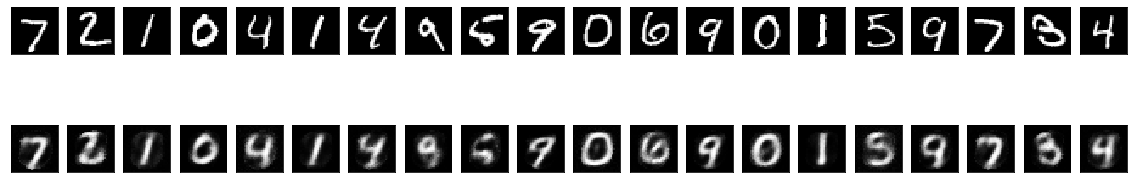

In [15]:
reconst_test = autoencoder.predict(X_test)
encode_test = encoder.predict(X_test)

n = 20
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Text(0.5, 1.0, 'Test accuracy: 3.0 %')

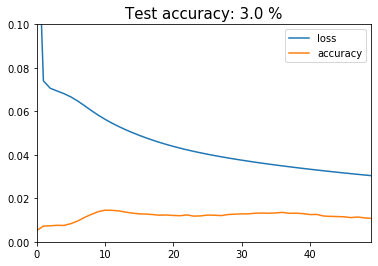

In [16]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot(ylim=(0,0.1))

plt.title("Test accuracy: {:3.1f} %".format(result[0]*100), fontsize=15)

In [17]:
encode_test.shape

(10000, 32)

In [18]:
reconst_test.shape

(10000, 784)

# LLE

In [23]:
X = encode_test
Y= 'gray'
n_neighbors = 30
print("Computing LLE embedding")
a = LocallyLinearEmbedding(n_components=2, n_neighbors=30)
data_2= a.fit_transform(X)
print("Done. Reconstruction error: %g" % a.reconstruction_error_)

Computing LLE embedding
Done. Reconstruction error: 2.85095e-08


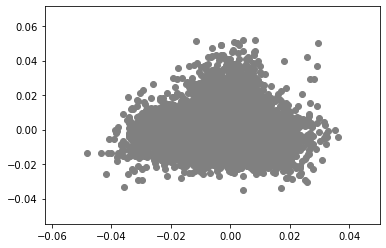

In [24]:
plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
plt.savefig("LLE.png")
plt.show()

In [25]:
from matplotlib import offsetbox

def plot_components(data, proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()    
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

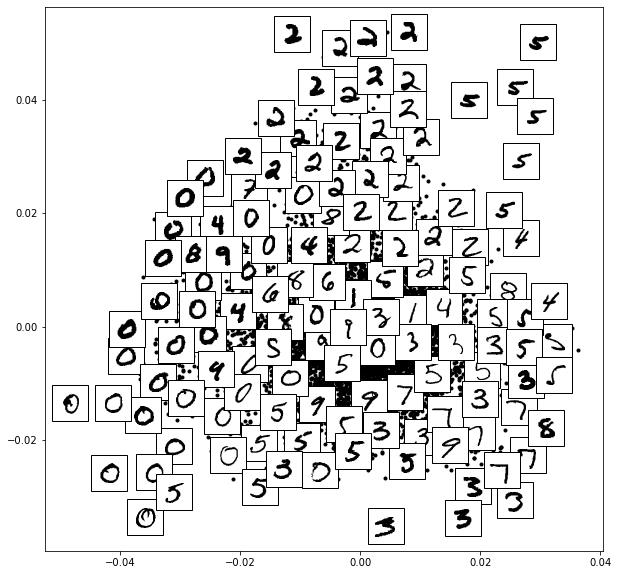

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_components(encode_test,data_2, images=X_test.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.055, cmap='gray_r')

# Loss Functions

In [27]:
def autoencoder_loss(X, reconstructed_X):
    return np.square(np.subtract(X, reconstructed_X)).mean()

In [28]:
def mse_objective(autoencoder_loss, lle_loss, lamda = 0.02):
    return autoencoder_loss + lamda*lle_loss

In [29]:
ae_loss = autoencoder_loss(X_test,reconst_test)
ae_loss

0.029876126

In [30]:
lle_loss=a.reconstruction_error_
lle_loss

2.850953653940004e-08

In [31]:
global_mse = mse_objective(ae_loss, lle_loss)
global_mse

0.029876126546634022

# Combination AE & LLE

In [32]:
mse = []
ae_mse = []
lle_mse = []
mse.append(global_mse)
ae_mse.append(ae_loss)
lle_mse.append(lle_loss)


In [33]:
iterations = 30

while global_mse > 0.001 and iterations > 0:
    #reload the data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train, X_validation, y_train, y_validation = train_test_split( X_train, y_train, test_size=0.8, random_state=42)
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    
    #Update AE params
    history =autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
               verbose = False)
    result = autoencoder.evaluate(X_test, X_test)
    reconst_test = autoencoder.predict(X_test)
    encode_test = encoder.predict(X_test)
    #Update LLE weights
    #a = LocallyLinearEmbedding(n_components=2, n_neighbors=30)
    data_2= a.fit_transform( encode_test)
    
    #Calculate global mse
    lle_loss=a.reconstruction_error_
    ae_loss = autoencoder_loss(X_test,reconst_test)
    global_mse = mse_objective(ae_loss, lle_loss)
    lle_mse.append(lle_loss)
    ae_mse.append(ae_loss)
    mse.append(global_mse)
    iterations =iterations -1
    print ('AE loss : ', ae_loss)
    print ('LLE loss : ', lle_loss)
    print ('Global loss : ', global_mse)

10000/10000 [==============================] - 1s 139us/step
AE loss :  0.025737243
LLE loss :  2.2540933805730547e-08
Global loss :  0.025737243223993917
10000/10000 [==============================] - 2s 156us/step
AE loss :  0.022718383
LLE loss :  3.134460996181759e-08
Global loss :  0.022718383626193155
10000/10000 [==============================] - 1s 103us/step
AE loss :  0.020320859
LLE loss :  4.602613781329865e-09
Global loss :  0.020320858898423964
10000/10000 [==============================] - 1s 108us/step
AE loss :  0.018385248
LLE loss :  2.087225574692382e-08
Global loss :  0.018385248676155024
10000/10000 [==============================] - 1s 91us/step
AE loss :  0.016890269
LLE loss :  1.891927904339585e-08
Global loss :  0.01689026915122608
10000/10000 [==============================] - 1s 92us/step
AE loss :  0.015769526
LLE loss :  4.983988595580182e-09
Global loss :  0.0157695264620989
10000/10000 [==============================] - 1s 82us/step
AE loss :  0.0149311

# Evaluation

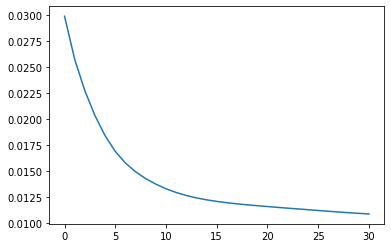

In [45]:
plt.plot(mse)
#plt.plot(lle_mse)
#plt.plot(ae_mse)

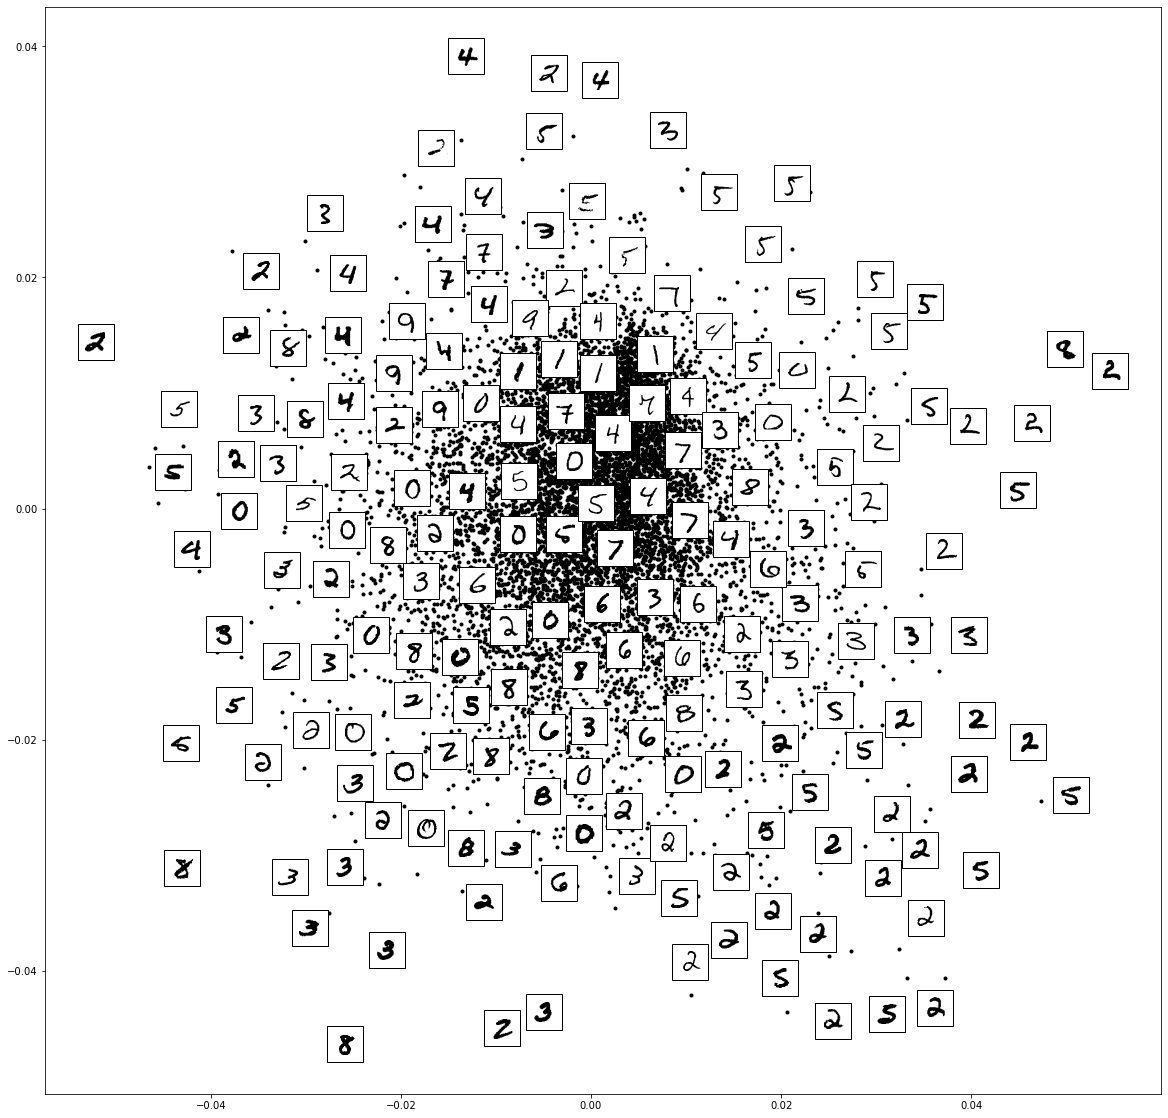

In [48]:
#Clustering & Visualisation
fig, ax = plt.subplots(figsize=(20, 20))
plot_components(encode_test,data_2, images=X_test.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.04, cmap='gray_r')

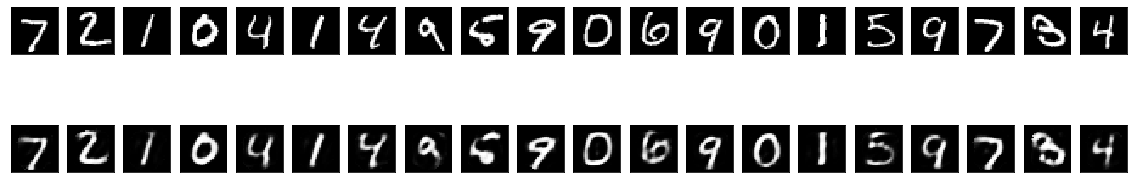

In [40]:
n = 20
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Outputs

In [41]:
#S weights matrix
S=a.nbrs_.kneighbors_graph()
S.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
# Encoding matrix
f = encode_test

In [43]:
# Embedding matrix
B = data_2